In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import util.util as util
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import glob

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve, auc
from scipy.optimize import brentq
from scipy.interpolate import interp1d

from tqdm import tqdm
import os.path as path
import torch.nn.functional as F
from models import networks

from PIL import Image
import random
import numpy as np
import cv2
import pandas as pd
import csv

from util.vggface import VGGFace as VggFace
from options.test_options import TestOptions
from models import create_model

import ipdb

In [2]:
# os.environ['CUDA_VISIBLE_DEVICES']='1'
gpu_ids = ['cuda:0']

In [3]:
gallery_root = '../../dataset/odin_data/Vis_128/'
# probe_root = '../../dataset/odin_data/S0_128_rec/'
# probe_root = '../../dataset/odin_data/S0_16/'
# probe_root = '../../dataset/odin_data/Polar_128_rec/'
probe_root = '../../dataset/odin_data/Polar_16/'
split_dir = '../../dataset/odin_data/splits/'

run_rec_metrics = True
run_id = True

args = "--dataset_mode aligned_arl3 --A_mode Polar --no_pose"
# args += " --dont_save_metrics"
# args += " --model pix2pix"
# args += " --model pix2pix_conf --netG SAGAN"
args += " --model pix2pix_conf"

exp = '001_axial_arl3_S0'

split = int(exp[-1])
args += " --split {}".format(split)

In [4]:
# Test PSNR and SSIM
if run_rec_metrics:
    cmd = "python test_metrics.py --name {} --dir_A {} --epoch {} {}".format(exp, probe_root, 'best', args)
    !{cmd}

----------------- Options ---------------
                   A_mode: Polar                         
                   B_mode: V1                            
             aspect_ratio: 1.0                           
               batch_size: 32                            
          checkpoints_dir: ./checkpoints                 
                 comments:                               
               conf_guide: False                         
                crop_size: 128                           
                 dataroot: ../../dataset/odin_data       
             dataset_mode: aligned_arl3                  	[default: aligned_arl]
                    dir_A: ../../dataset/odin_data/Polar_16/	[default: ../../dataset/odin_data/Polar_128]
                    dir_B: ../../dataset/odin_data/Vis_128
                direction: AtoB                          
          display_winsize: 128                           
                    epoch: best                          
                

In [5]:
# Test PSNR and SSIM
if run_rec_metrics:
    cmd = "python test_metrics.py --name {} --dir_A {} --epoch {} {}".format(exp, probe_root, 'best_ssim', args)
    !{cmd}

----------------- Options ---------------
                   A_mode: Polar                         
                   B_mode: V1                            
             aspect_ratio: 1.0                           
               batch_size: 32                            
          checkpoints_dir: ./checkpoints                 
                 comments:                               
               conf_guide: False                         
                crop_size: 128                           
                 dataroot: ../../dataset/odin_data       
             dataset_mode: aligned_arl3                  	[default: aligned_arl]
                    dir_A: ../../dataset/odin_data/Polar_16/	[default: ../../dataset/odin_data/Polar_128]
                    dir_B: ../../dataset/odin_data/Vis_128
                direction: AtoB                          
          display_winsize: 128                           
                    epoch: best_ssim                     	[default: best]


In [6]:
# Test PSNR and SSIM
if run_rec_metrics and run_id:
    cmd = "python test_metrics.py --name {} --dir_A {} --epoch {} {}".format(exp, probe_root, 'best_id', args)
    !{cmd}

----------------- Options ---------------
                   A_mode: Polar                         
                   B_mode: V1                            
             aspect_ratio: 1.0                           
               batch_size: 32                            
          checkpoints_dir: ./checkpoints                 
                 comments:                               
               conf_guide: False                         
                crop_size: 128                           
                 dataroot: ../../dataset/odin_data       
             dataset_mode: aligned_arl3                  	[default: aligned_arl]
                    dir_A: ../../dataset/odin_data/Polar_16/	[default: ../../dataset/odin_data/Polar_128]
                    dir_B: ../../dataset/odin_data/Vis_128
                direction: AtoB                          
          display_winsize: 128                           
                    epoch: best_id                       	[default: best]


In [7]:
model = VggFace()
model.load_state_dict(torch.load(os.path.join('./checkpoints/', "vggface.pth")))
model.to(gpu_ids[0])
model.eval()
    
data_transforms = transforms.Compose([
        transforms.Resize([128, 128]),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

pix2pix_transform = transforms.Compose([
#         transforms.Resize([128, 128]),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# vgg_transforms = transforms.Compose([
#         transforms.Resize([128, 128]),
#         transforms.ToTensor(),
# #         transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ])

In [8]:
def display_result(fpr, tpr, thresholds, roc_auc):
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    thresh = interp1d(fpr, thresholds)(eer)
    f = interp1d(fpr, tpr)
    
    l1 = 'AUC: %f ' % (roc_auc)
    l2 = 'EER: %f ' % (eer)
    l3 = "FAR=0.01: %f " % (f(0.01))
    l4 = "FAR=0.05: %f " % (f(0.05))
    
    print(l1, l2, l3, l4, sep='\n')    
    ret = [roc_auc, eer, f(0.01), f(0.05)]
    ret = [round(x*100,2) for x in ret]
    return ret

In [9]:
def get_id(x):
    return x.split('_')[2][:-1]

def remove_pose(paths):
    paths = [x for x in paths if '_p_' not in x]
    print('Removed pose images')
    return paths

def compute_probe():
    print('Computing embeddings of', probe_imgs)
    
    fp = open(probe_imgs).readlines()
    if opt.no_pose:
        fp = remove_pose(fp)
    count_num = len(fp)
    outputs_probe = np.zeros((count_num,25088))
    namelist_probe = []
    
    for cnt, line in enumerate(tqdm(fp)):
        A_data = line.rstrip().replace('V1',opt.A_mode)
        A_path = os.path.join(probe_root, A_data)
        name = get_id(A_data)

        A_img = Image.open(A_path)    
        var_A = pix2pix_transform(A_img).unsqueeze(0)
        var_A = var_A.to(gpu_ids[0])
        d1_A = model_A(var_A)

        feat_probe = model(F.interpolate(d1_A, size=(224, 224), mode='bilinear', align_corners=True))[-1]
        outputs_probe[cnt,:] = feat_probe.view(1,-1).cpu().data[0]
        namelist_probe.append(name)

    return outputs_probe, namelist_probe

def compute_gallery():
    print('Computing embeddings of', gallery_imgs)
    
    fp = open(gallery_imgs).readlines()
    if opt.no_pose:
        fp = remove_pose(fp)
    count_num = len(fp)
    outputs_gallery = np.zeros((count_num,25088))
    namelist_gallery = []
    
    for cnt, line in enumerate(tqdm(fp)):
        B_data = line.rstrip()
        B_path = os.path.join(gallery_root, B_data)
        name = get_id(B_data)

        B_img = Image.open(B_path).convert('RGB')
        var_B = data_transforms(B_img).unsqueeze(0)

        var_B = var_B.to(gpu_ids[0])
        feat_gallery = model(F.interpolate(var_B, size=(224, 224), mode='bilinear', align_corners=True))[-1]
        outputs_gallery[cnt,:] = feat_gallery.view(1,-1).cpu().data[0]
        namelist_gallery.append(name)

    return outputs_gallery, namelist_gallery

def compute_result():
    similary_matrix = np.asarray(cosine_similarity(outputs_probe,outputs_gallery))
    gt_matrix = np.zeros([similary_matrix.shape[0], similary_matrix.shape[1]])
    for i in range(similary_matrix.shape[0]):
        for j in range(similary_matrix.shape[1]):
            if namelist_probe[i] == namelist_gallery[j]:
                gt_matrix[i, j] = 1
            else:
                gt_matrix[i, j] = -1
    
    # save result matrix
    gallery_id = os.path.splitext(gallery_imgs.split("/")[-1])[0]
    probe_id = os.path.splitext(probe_imgs.split("/")[-1])[0]
    
    pd.DataFrame(gt_matrix).to_csv(os.path.join(sim_matrix_folder, "gt_" + gallery_id + "_" + probe_id + ".csv"))
    pd.DataFrame(similary_matrix).to_csv(os.path.join(sim_matrix_folder, "pred_" + gallery_id + "_" + probe_id + ".csv"))
    
    print(gallery_id, probe_id)
    print("Gallery size:", len(namelist_gallery))
    print("Probe size:", len(namelist_probe))
    
    # compute scores                 
    fpr, tpr, thresholds = roc_curve(gt_matrix.reshape(-1), similary_matrix.reshape(-1))
    roc_auc = auc(fpr, tpr)
    roc_data[(gallery_id, probe_id)] = (fpr, tpr, thresholds)
    
    row = display_result(fpr, tpr, thresholds, roc_auc)
    if not opt.dont_save_metrics:
        with open(verf_file,'a') as f:
            csvwriter = csv.writer(f)
            row = ['{},{}'.format(gallery_id, probe_id)] + row
            csvwriter.writerow(row)

    plt.imshow(gt_matrix)
    plt.show()
    plt.imshow(similary_matrix)
    plt.show()

In [10]:
split_args = ""
if len(args) > 0:
    split_args = args.split(" ")
opt = TestOptions().parse(split_args)
opt.name = exp
opt.dir_A = probe_root

mxroot = os.path.join(opt.results_dir, exp)
verf_file = os.path.join(mxroot, 'all_metrics.csv')

# gallery data remains same
gallery_ids = [opt.split]
gallery_data = {}
gallery_dir = os.path.join(opt.checkpoints_dir, opt.dataset_mode.split('_')[-1])
os.makedirs(gallery_dir, exist_ok=True)
gallery_feats_path = os.path.join(gallery_dir, 'gallery_feats_{}_s{}.npy'.format(opt.A_mode, opt.split))
if os.path.exists(gallery_feats_path):
    print('Loading gallery data')
    gallery_data = np.load(gallery_feats_path, allow_pickle=True).item()
else:
    for id_ in gallery_ids:
        gallery_imgs = os.path.join(split_dir, 'gallery_{}.txt'.format(id_))
        gallery_data[id_] = compute_gallery()
    print('Saving gallery data')
    np.save(gallery_feats_path, gallery_data)
    
probe_ids = [opt.split]

----------------- Options ---------------
                   A_mode: Polar                         	[default: FLIR_USB]
                   B_mode: BAS_RGB2                      
             aspect_ratio: 1.0                           
               batch_size: 32                            
          checkpoints_dir: ./checkpoints                 
                 comments:                               
               conf_guide: False                         
                crop_size: 128                           
                 dataroot: ../../dataset/Odin3           
             dataset_mode: aligned_arl3                  	[default: aligned_arl]
                    dir_A: ../../dataset/Odin3/16_bicubic
                dir_A_rec: ../../dataset/Odin3/rec_bicubic
                    dir_B: ../../dataset/Odin3/cropped_images
                direction: AtoB                          
          display_winsize: 128                           
                    epoch: best         

  0%|          | 0/1076 [00:00<?, ?it/s]

initialize network with xavier
model [Pix2PixConfModel] was created
loading the model from ./checkpoints/001_axial_arl3_polar_nopose_S3/best_net_G.pth
---------- Networks initialized -------------
[Network G] Total number of parameters : 4.146 M
-----------------------------------------------
Computing embeddings of ../../dataset/odin_data/splits/probe_3.txt
Removed pose images


100%|██████████| 1076/1076 [00:15<00:00, 70.11it/s]


gallery_3 probe_3
Gallery size: 30
Probe size: 1076
AUC: 0.791304 
EER: 0.266814 
FAR=0.01: 0.298855 
FAR=0.05: 0.521648 


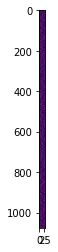

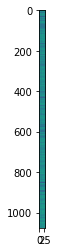

In [11]:
opt.epoch = 'best'

sim_matrix_folder = os.path.join(mxroot, 'similarity_matrix_' + opt.epoch)
os.makedirs(sim_matrix_folder, exist_ok=True)

full_model = create_model(opt)
full_model.setup(opt)
model_A = full_model.netG
model_A.eval()

if not opt.dont_save_metrics:
    now = time.strftime("%c")
    with open(verf_file,'a') as f:
        csvwriter = csv.writer(f)
        rows = [['Verification metrics', now, 'Epoch_{}'.format(opt.epoch)], 
                ['Protocol', 'AUC', 'EER', 'FAR=1%','FAR=5%']]
        csvwriter.writerows(rows)

probe_data = {}
for id_ in probe_ids:
    probe_imgs = os.path.join(split_dir, 'probe_{}.txt'.format(id_))
    probe_data[id_] = compute_probe()

roc_data = {}    
# compute result for all combinations of gallery and probe
for gid in gallery_data.keys():
    for pid in probe_data.keys():
        gallery_imgs = os.path.join(split_dir, 'gallery_{}.txt'.format(gid))
        probe_imgs = os.path.join(split_dir, 'probe_{}.txt'.format(pid))
        
        outputs_gallery, namelist_gallery = gallery_data[gid]
        outputs_probe, namelist_probe = probe_data[pid]
        compute_result()
        
roc_path = os.path.join(mxroot, 'roc_' + opt.epoch + '.npy')        
np.save(roc_path, roc_data)           

  1%|          | 8/1076 [00:00<00:13, 76.75it/s]

initialize network with xavier
model [Pix2PixConfModel] was created
loading the model from ./checkpoints/001_axial_arl3_polar_nopose_S3/best_ssim_net_G.pth
---------- Networks initialized -------------
[Network G] Total number of parameters : 4.146 M
-----------------------------------------------
Computing embeddings of ../../dataset/odin_data/splits/probe_3.txt
Removed pose images


100%|██████████| 1076/1076 [00:14<00:00, 74.63it/s]


gallery_3 probe_3
Gallery size: 30
Probe size: 1076
AUC: 0.788367 
EER: 0.267458 
FAR=0.01: 0.286131 
FAR=0.05: 0.513749 


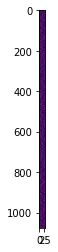

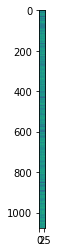

In [12]:
opt.epoch = 'best_ssim'

sim_matrix_folder = os.path.join(mxroot, 'similarity_matrix_' + opt.epoch)
os.makedirs(sim_matrix_folder, exist_ok=True)

full_model = create_model(opt)
full_model.setup(opt)
model_A = full_model.netG
model_A.eval()

if not opt.dont_save_metrics:
    now = time.strftime("%c")
    with open(verf_file,'a') as f:
        csvwriter = csv.writer(f)
        rows = [['Verification metrics', now, 'Epoch_{}'.format(opt.epoch)], 
                ['Protocol', 'AUC', 'EER', 'FAR=1%','FAR=5%']]
        csvwriter.writerows(rows)

probe_data = {}
for id_ in probe_ids:
    probe_imgs = os.path.join(split_dir, 'probe_{}.txt'.format(id_))
    probe_data[id_] = compute_probe()
    
roc_data = {}    
# compute result for all combinations of gallery and probe
for gid in gallery_data.keys():
    for pid in probe_data.keys():
        gallery_imgs = os.path.join(split_dir, 'gallery_{}.txt'.format(gid))
        probe_imgs = os.path.join(split_dir, 'probe_{}.txt'.format(pid))
        
        outputs_gallery, namelist_gallery = gallery_data[gid]
        outputs_probe, namelist_probe = probe_data[pid]
        compute_result()
        
roc_path = os.path.join(mxroot, 'roc_' + opt.epoch + '.npy')        
np.save(roc_path, roc_data)           

  1%|          | 8/1076 [00:00<00:13, 76.86it/s]

initialize network with xavier
model [Pix2PixConfModel] was created
loading the model from ./checkpoints/001_axial_arl3_polar_nopose_S3/best_id_net_G.pth
---------- Networks initialized -------------
[Network G] Total number of parameters : 4.146 M
-----------------------------------------------
Computing embeddings of ../../dataset/odin_data/splits/probe_3.txt
Removed pose images


100%|██████████| 1076/1076 [00:14<00:00, 75.22it/s]


gallery_3 probe_3
Gallery size: 30
Probe size: 1076
AUC: 0.788437 
EER: 0.266061 
FAR=0.01: 0.307263 
FAR=0.05: 0.497207 


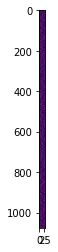

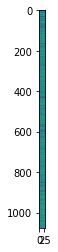

In [13]:
opt.epoch = 'best_id'

full_model = create_model(opt)
full_model.setup(opt)
model_A = full_model.netG
model_A.eval()

sim_matrix_folder = os.path.join(mxroot, 'similarity_matrix_' + opt.epoch)
os.makedirs(sim_matrix_folder, exist_ok=True)

if not opt.dont_save_metrics:
    now = time.strftime("%c")
    with open(verf_file,'a') as f:
        csvwriter = csv.writer(f)
        rows = [['Verification metrics', now, 'Epoch_{}'.format(opt.epoch)], 
                ['Protocol', 'AUC', 'EER', 'FAR=1%','FAR=5%']]
        csvwriter.writerows(rows)

probe_data = {}
for id_ in probe_ids:
    probe_imgs = os.path.join(split_dir, 'probe_{}.txt'.format(id_))
    probe_data[id_] = compute_probe()
    
roc_data = {}    
# compute result for all combinations of gallery and probe
for gid in gallery_data.keys():
    for pid in probe_data.keys():
        gallery_imgs = os.path.join(split_dir, 'gallery_{}.txt'.format(gid))
        probe_imgs = os.path.join(split_dir, 'probe_{}.txt'.format(pid))
        
        outputs_gallery, namelist_gallery = gallery_data[gid]
        outputs_probe, namelist_probe = probe_data[pid]
        compute_result()
        
roc_path = os.path.join(mxroot, 'roc_' + opt.epoch + '.npy')        
np.save(roc_path, roc_data)           